# 【問題1】K-meansクラスの作成

## インポート

In [1]:
import sys
from sklearn.datasets import make_blobs
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append(
    '/Users/takahashiakira/Documents/DIC/diveintocode-ml/ ml-scratch/model')
sys.path.append(
    '/Users/takahashiakira/Documents/DIC/diveintocode-ml/ ml-scratch/utils')
from decision_region import decision_region2

## データセットの準備

クラスタリングを実験するための人工データセットを作成するコードを用意しました。スクラッチの過程で利用してください。  
このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。

In [2]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4,
                  cluster_std=0.5, shuffle=True, random_state=0)

**目的関数**  

K-meansは以下のクラスタ内誤差平方和（SSE, Sum of Squared Errors）を最小化する   
$ r_{nk} $ と $μ_k$ を求めることで学習を行います。この数式自体は学習時にはコーディングする必要がありませんが、クラスタ数 K を決めるためのエルボー法で使います。  
エルボー法の実装は問題2で扱います。
$$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$$

$n$ : データ点のインデックス  
$k$ : クラスタのインデックス  
$X_n$ : n番目のデータ点  
$μ_k$ : k番目の中心点  
$r_{nk}$ : データ点Xnがクラスタkに所属していたら1、そうでなければ0  

**学習**

K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。  
- 中心点 $μ_k$ を固定した上で $J$ を最小化する $r_{nk}$ を選ぶ。  
- $r_{nk}$ を固定した上で $J$ を最小化する $μ_k$ を選ぶ。  

具体的には以下を行います。  
まずは  
- 中心点 $μ_k$ の初期値を決める。  

その後以下を繰り返します。  
- データ点 $X_n$ を最も近い $μ_k$ に割り当てる。  
- 中心点 $μ_k$ を k 番目のクラスタに割り当てられる全てのデータ点 $X_n$ の平均値（重心）に移動する。  

次のどれかの条件を満たしたらこれを止めます。  
- 繰り返しが指定した回数に到達する。  
- 中心点 $μ_k$ と重心の差が指定した許容値以下になる。  
- データ点 $X_n$ のクラスタへの割り当てが変化しなくなる。  

さらに、
- ここまでの一連の流れを指定した回数繰り返す。  
- SSEが最小になったものを最終的な学習結果とする。  

これで学習が完了します。  
考慮すべき点として、空のクラスタが生じる可能性があります。これを防ぐためには以下の動作を実装します。  
- k 番目のクラスタに割り当てられるデータ点 $X_n$ が存在しない場合、中心点 $μ_k$ を最も離れているデータ点の場所に移動する。  
繰り返し回数や許容値などのハイパーパラメータの値はscikit-learnのデフォルト値を参考にしてください。  

**ユークリッド距離**

K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。  
ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル p,q に対しては以下の数式で表現できます。
$$
\|q-p\| = \sqrt{(q-p)\cdot(q-p)}
$$

**初期値**

K-meansの学習結果は中心点 $μ$ の初期値に影響を受けます。  
最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに k 個選ぶことです。今回はこれを実装してください。  
K-meansのより良い初期値の選択方法については研究が行われており、いろいろな方法が提案されています。

**推定**

新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。  

- データ点 $X_n$ に対し、学習で決まった中心点 $μ_k$ の元、 $J$ を最小化する $r_{nk}$を選ぶ。  

具体的には次のことです。  

- データ点 $X_n$ を最も近い $μ_k$ に割り当てる。

## まずは仕組みを理解するため、クラスは作成せずに確認していく。

In [3]:
# 初期値の設定
error_thre = 0.1
np.random.seed(0)
# Xの中からランダムで3点クラスタを選ぶ。
first_points = np.random.choice(len(X), 3)
X[first_points]

array([[-1.87418794,  2.84306499],
       [-1.84482705,  3.25609891],
       [ 1.42002502,  1.38236201]])

In [4]:
# 初期値からのそれぞれの距離を算出。１点の場合
normX = np.linalg.norm(X - X[first_points][0], axis=1)
normX

array([2.73713716, 5.12596144, 3.57132412, 3.36074934, 4.03260323,
       2.96201514, 1.03321547, 5.15503917, 3.15022713, 4.89265167,
       4.28953069, 4.22188486, 4.44984528, 4.98625305, 4.7844998 ,
       5.53060335, 3.48178369, 1.63320242, 0.09129491, 5.17787793,
       4.05228058, 4.77377038, 0.34649609, 4.96868579, 2.91708355,
       0.39350632, 1.54181264, 3.08737204, 4.77883716, 4.95607385,
       4.17464355, 4.29516271, 4.55546341, 4.07303229, 0.84578383,
       3.17969857, 5.96907308, 3.95942235, 5.91259569, 0.3393311 ,
       3.6507007 , 0.58254557, 3.89259199, 0.6426584 , 0.        ,
       5.41459264, 4.14763566, 0.41407618, 2.8773403 , 2.4520931 ,
       2.8925723 , 4.23282005, 0.63625582, 1.0078306 , 1.02252575,
       4.66394159, 5.49805426, 4.68788485, 4.40539723, 5.29336328,
       4.32826451, 3.67845008, 4.35732681, 4.23100171, 3.60353885,
       5.44840365, 0.34762612, 0.72100751, 4.28870138, 3.47685605,
       5.33430218, 3.66559664, 3.25717383, 5.01695958, 3.18199

In [5]:
# 行列とインデックスを渡すとそのインデックスからの距離を算出する関数を作成
def norm_culc_i(X, point):
    """
    X: ndarray ,shape(n_samples, n_features)
    point: int
    """
    return np.linalg.norm(X - X[point], axis=1)

In [6]:
# 初期値の数だけfor文を回して距離の行列を初期値の数だけ作成
norm_list = []
for i in range(len(first_points)):
    norm_list.append(norm_culc_i(X, first_points[i]))
norm_list

[array([2.73713716, 5.12596144, 3.57132412, 3.36074934, 4.03260323,
        2.96201514, 1.03321547, 5.15503917, 3.15022713, 4.89265167,
        4.28953069, 4.22188486, 4.44984528, 4.98625305, 4.7844998 ,
        5.53060335, 3.48178369, 1.63320242, 0.09129491, 5.17787793,
        4.05228058, 4.77377038, 0.34649609, 4.96868579, 2.91708355,
        0.39350632, 1.54181264, 3.08737204, 4.77883716, 4.95607385,
        4.17464355, 4.29516271, 4.55546341, 4.07303229, 0.84578383,
        3.17969857, 5.96907308, 3.95942235, 5.91259569, 0.3393311 ,
        3.6507007 , 0.58254557, 3.89259199, 0.6426584 , 0.        ,
        5.41459264, 4.14763566, 0.41407618, 2.8773403 , 2.4520931 ,
        2.8925723 , 4.23282005, 0.63625582, 1.0078306 , 1.02252575,
        4.66394159, 5.49805426, 4.68788485, 4.40539723, 5.29336328,
        4.32826451, 3.67845008, 4.35732681, 4.23100171, 3.60353885,
        5.44840365, 0.34762612, 0.72100751, 4.28870138, 3.47685605,
        5.33430218, 3.66559664, 3.25717383, 5.01

In [7]:
# 3点のクラスタとの距離の中で最も近いインデックスを取得、そのインデックスが所属クラスタとなる。
rabel = np.argmin(norm_list, axis=0)
rabel

array([2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 2, 1,
       1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1,
       0, 1, 2, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1,
       0, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 2,
       2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

#### ラベルごとの平均(重心)を取りたい

In [8]:
# 所属クラスタのインデックスをワンホットベクトル化する。
onehot_rabel = np.eye(int(np.max(rabel)) + 1)[rabel.astype("int")]
onehot_rabel[onehot_rabel == 0] = np.nan
onehot_rabel

array([[nan, nan,  1.],
       [nan,  1., nan],
       [nan, nan,  1.],
       [nan, nan,  1.],
       [nan, nan,  1.],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan, nan,  1.],
       [nan, nan,  1.],
       [nan,  1., nan],
       [ 1., nan, nan],
       [nan, nan,  1.],
       [nan, nan,  1.],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan, nan,  1.],
       [nan,  1., nan],
       [ 1., nan, nan],
       [nan,  1., nan],
       [nan,  1., nan],
       [nan, nan,  1.],
       [nan, nan,  1.],
       [nan, nan,  1.],
       [nan,  1., nan],
       [nan, nan,  1.],
       [nan, nan,  1.],
       [nan,  1., nan],
       [nan, nan,  1.],
       [nan,  1., nan],
       [nan, nan,  1.],
       [nan,  1., nan],
       [ 1., nan, nan],
       [nan,  1., nan],
       [nan,  1.

In [9]:
# shapeを増やしワンホットベクトルされた特徴量の列を3次元目に配置する。
# Xにかければラベルつけされた次元の所だけ残る。
grooping_X = X.reshape(-1, 2, 1) * onehot_rabel.reshape(-1, 1, 3)
grooping_X

array([[[        nan,         nan,  0.72086751],
        [        nan,         nan,  3.71347124]],

       [[        nan, -1.89468423,         nan],
        [        nan,  7.96898545,         nan]],

       [[        nan,         nan,  1.35678894],
        [        nan,         nan,  4.36462484]],

       [[        nan,         nan,  1.05374379],
        [        nan,         nan,  4.49286859]],

       [[        nan,         nan,  1.59141542],
        [        nan,         nan,  4.90497725]],

       [[        nan,  0.78260667,         nan],
        [        nan,  4.15263595,         nan]],

       [[        nan, -1.95751686,         nan],
        [        nan,  3.87291474,         nan]],

       [[        nan, -0.77354537,         nan],
        [        nan,  7.87923564,         nan]],

       [[        nan,  0.12313498,         nan],
        [        nan,  5.27917503,         nan]],

       [[        nan, -1.43284669,         nan],
        [        nan,  7.71577043,         nan]],



In [10]:
# grooping_Xについて平均を取れば、それぞれのクラスタにおける重心値が求まる。
temp_center_cluster = np.nanmean(grooping_X, axis=0).T
temp_center_cluster

array([[-1.53215923,  2.63263186],
       [-0.86399249,  5.73057633],
       [ 1.76669401,  2.00638222]])

In [11]:
#重心値が初めの初期値と比べて、設定した閾値よりも遠かった場合は。重心値を次の初期値として設定する。
error_thre = 0.1
center_cluster = temp_center_cluster[np.linalg.norm(
    X[first_points] - temp_center_cluster, axis=1) > error_thre]
center_cluster

array([[-1.53215923,  2.63263186],
       [-0.86399249,  5.73057633],
       [ 1.76669401,  2.00638222]])

#### 上記流れを繰り返す。

In [12]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4,
                  cluster_std=0.5, shuffle=True, random_state=0)

In [13]:
# インデックスではなく、Xと中心点を渡すとその距離を算出する関数
def norm_culc(X, center):
    """
    X: ndarray, shape(n_samples, n_features, 1)
    center: ndarray, shape(1, n_features, n_center)
    
    -------------------------
    return
    
    norm:ndarray, shape(n_samples, n_center)
    """
    return np.linalg.norm(X - center, axis=1)

In [14]:
# 初期値の設定
np.random.seed(0)
first_points = np.random.choice(len(X), 3)
center_cluster = X[first_points]

In [15]:
#　中心地の数だけXとの距離を計算する。Xとクラスターの次元を増やしておく。
norm_list = norm_culc(X.reshape(-1, 2, 1), center_cluster.reshape(-1, 2, 1).T)

# 最小値のインデックス算出
rabel = np.argmin(norm_list, axis=1)

# インデックスをワンホットベクトル化する。
onehot_rabel = np.eye(int(np.max(rabel))+1)[rabel.astype("int")]
onehot_rabel[onehot_rabel == 0] = np.nan

# shapeを増やしワンホットベクトルされた特徴量の列を3次元目に配置する。
# Xにかければラベルつけされた次元の所だけ残る。
#grooping_X.shape ( n_sample, n_feature, n_cluster)
grooping_X = X.reshape(-1, 2, 1) * onehot_rabel.reshape(-1, 1, 3)

# nanを除いて形を整えればそれぞれの重心が計算される。
temp_center_cluster = np.nanmean(grooping_X, axis=0).T
print(np.linalg.norm(center_cluster - temp_center_cluster, axis=1))
center_cluster[np.linalg.norm(center_cluster - temp_center_cluster, axis=1) >
               error_thre] = temp_center_cluster[np.linalg.norm(center_cluster - temp_center_cluster, axis=1) > error_thre]
center_cluster

[0.40157906 2.66178041 0.71384915]


array([[-1.53215923,  2.63263186],
       [-0.86399249,  5.73057633],
       [ 1.76669401,  2.00638222]])

## クラス作成

In [16]:
class ScratchKMeans():
    """
    KMeansのスクラッチ実装
    
    Parameters
    ----------
    self.n_clusters : int (5)
        クラスタ数
    self.tol_thre : float(1e-4)
        クラスタ重心と中心点とのズレの閾値。ここより小さくなったら学習終了
    self.n_init : int(10)
        初期値を取る回数
    self.max_iter : int(300)
        一回の学習で重心を動かす最高回数。
    self.seed : int(None)
        ランダムシード
        
    Attributes
    ----------
    sse : float 最終的なSSE
    label : ndarray, shape(n_samples, )
      Xの各サンプル毎の予測ラベル値
    center_cluster: ndarray, shape (n_cluster, n_features)
      各クラスター中心座標
    """

    def __init__(self,
                 n_clusters=5,
                 tol_thre=1e-4,
                 n_init=10, #初期値を取る回数
                 max_iter=300,
                 seed=None,):
        # 様々なパラメータを初期化
        self.n_clusters = n_clusters  
        self.tol_thre = tol_thre
        self.n_init = n_init
        self.max_iter = max_iter
        self.seed = seed
        self.center_cluster = None

    def norm_culc(self, X, center):
        """
        Xと初期値を与えるとそれぞれの距離を全て出してくれる。
        X: ndarray, shape(n_samples, n_features, 1)
        center: ndarray, shape(1, n_features, n_cluster)

        return
        -------------------------------
        norm : ndarray, shape(n_samples, n_cluster)

        """
        return np.linalg.norm(X - center, axis=1)

    def SSE(self, X, center_cluster, onehot_label):
        """
        SSEを計算するメソッド
        X: ndarray, shape(n_samples, n_features, 1)
        center: ndarray, shape(1, n_features, n_cluster)
        onehot_label : ndarray, shape(n_samples, 1, n_cluster)
        """
        error = (X - center_cluster) * \
            onehot_label  # 誤差に対してワンホットベクトル化されたラベルを掛けてあげたもの。
        return np.nansum(error**2)

    def fit(self, X):
        """
        k-meansを学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        学習用データの特徴量
        """

        n_features = X.shape[1]
        self.sse = None
        self.label = None

        # 次元を増やしたXを作成しておく →初期値の数だけブロードキャスト出来るように
        X_copy = X[:, :, np.newaxis]

        # 初期値の設定
        np.random.seed(self.seed)

        # 初期値を変えた繰り返しの始まり
        for init in range(self.n_init):
            first_points = np.random.choice(len(X),
                                            self.n_clusters,
                                            replace=False)  # ランダムでインデックスを取得
            # 初期値を中心値と設定。転置が必要(z軸方向に初期値の数だけ伸びていく。)
            center_cluster = X_copy[first_points].T

            label = None  # ラベルの初期化

            # 学習ゾーン
            for ite in range(self.max_iter):

                #　中心値とXとの距離を計算する。
                norm_list = self.norm_culc(X_copy, center_cluster)

                # ノルム最小値のインデックス取得
                templabel = np.argmin(norm_list, axis=1)
                
                # ラベルが前回の分と比較して変わらなかったら学習終了
                if (label == templabel).all():
                    break
                else:
                    label = templabel
                
                # インデックスをワンホットベクトル化する。次元も３次元に設定
                onehot_label = np.eye(int(np.max(label)) + 1)[label.astype("int")].reshape(-1, 1, self.n_clusters)
                onehot_label[onehot_label == 0] = np.nan
                grooping_X = X_copy * onehot_label  # Xにかけるとラベルつけされた特徴量だけ残る。

                # 空のクラスが生じた場合、重心点を最も遠いデータ点へ移動する。
                # ラベルのユニーク値の数が初期クラスター数と異なる場合、空のクラスタがある。
                if len(np.unique(label)) != self.n_clusters:
                    ones = np.ones(n_clusters, bool)
                    # 空のクラスタがTrueになった配列を用意する。
                    ones[np.unique(label)] = False
                    # norm_listから空のクラスタを呼び出し、その中から最大値(最も離れている)のインデックスを取得する。
                    far_index = np.argmax(norm_list[:, ones])
                    # 空のクラスタに最大値のX_copyのデータを置き換える。
                    center_cluster[ones] = X_copy[far_index]

                # 平均(重心)を計算する。
                temp_center_cluster = np.nanmean(grooping_X, axis=0)[np.newaxis, :, :]
                tol = np.linalg.norm(center_cluster - temp_center_cluster,
                                     axis=1)  # 重心と中心点との差

                if tol.mean() < self.tol_thre:  # tolの平均が閾値より低ければ学習終了
                    print('tol が{}より低い！'.format(self.tol_thre))
                    break

                center_cluster = temp_center_cluster  # tolが閾値より大きい物は中心点を重心と置き換える。

            # 学習が終了したもので、SSEを計算する。
            temp_sse = self.SSE(X_copy, center_cluster, onehot_label)

            # 一回目の学習か、SSEが今までより低かった場合はベストプラクティスとして保存する。
            if self.sse is None or temp_sse < self.sse:
                self.center_cluster = center_cluster.T.reshape(self.n_clusters, -1)
                self.sse = temp_sse
                self.label = label  # もともとのXにラベル付けする

    def predict(self, X):

        # 次元を増やしたXを作成しておく →初期値の数だけブロードキャスト出来るように
        X_copy = X[:,:,np.newaxis]

        #　中心値とXとの距離を計算する。
        norm_list = self.norm_culc(X_copy, self.center_cluster.T[np.newaxis,:,:])

        # ノルム最小値のインデックス取得
        label = np.argmin(norm_list, axis=1)
        return label


### 試してみる。

In [17]:
import time
# 処理前の時刻
t1 = time.time() 
 
kmean = ScratchKMeans(n_clusters=4,seed=0)
kmean.fit(X)

#処理後の時刻
t2 = time.time()
 
# 経過時間を表示
elapsed_time = t2-t1
print('経過時間：{}'.format(elapsed_time))

経過時間：0.013010025024414062


In [18]:
import time
# 処理前の時刻
t1 = time.time() 
 
skmean = KMeans(n_clusters=4,random_state=0)
skmean.fit(X)

#処理後の時刻
t2 = time.time()
 
# 経過時間を表示
elapsed_time = t2-t1
print('経過時間：{}'.format(elapsed_time))

経過時間：0.01983785629272461


**sklearnより早い!**

### 大きいデータの場合

In [19]:
train = pd.read_csv('application_train.csv')
df = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2']].dropna()
X = df.drop('TARGET', axis = 1).values
y = df.TARGET.values
X.shape, y.shape

((133922, 2), (133922,))

In [20]:
# 処理前の時刻
t1 = time.time() 
 
kmean = ScratchKMeans(n_clusters=100,seed=0,tol_thre=1e-3)
kmean.fit(X)
print(kmean.sse)
#処理後の時刻
t2 = time.time()
 
# 経過時間を表示
elapsed_time = t2-t1
print('経過時間：{}'.format(elapsed_time))

tol が0.001より低い！
tol が0.001より低い！
tol が0.001より低い！
tol が0.001より低い！
tol が0.001より低い！
tol が0.001より低い！
tol が0.001より低い！
tol が0.001より低い！
tol が0.001より低い！
tol が0.001より低い！
130.31836710531252
経過時間：155.8406081199646


In [21]:
# 処理前の時刻
t1 = time.time() 
 
kmean = KMeans(n_clusters=100,random_state=0,tol=1e-3)
kmean.fit(X)
print(kmean.inertia_)

#処理後の時刻
t2 = time.time()
 
# 経過時間を表示
elapsed_time = t2-t1
print('経過時間：{}'.format(elapsed_time))

126.37634631957474
経過時間：79.25084495544434


**大きいデータとなるとsklearnが早い。**

## 【問題2】エルボー法の実装

K-meansにおいて中心点の個数 k は人為的に決める必要があるが、その判断方法としてエルボー法があります。  
SSEを縦軸、クラスタ数 k を横軸にした折れ線グラフを表示します。  
このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

In [22]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4,
                  cluster_std=0.5, shuffle=True, random_state=0)

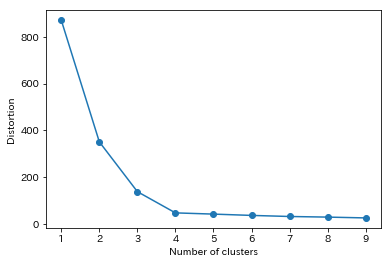

In [23]:
distortions = []
for i in range(1,10):
    km = ScratchKMeans(n_clusters=i,
                       seed=0)
    km.fit(X)                         # クラスタリングの計算を実行
    distortions.append(km.sse)   # km.fitするとkm.inertia_が得られる
plt.plot(range(1,10),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()    

# 卸売業者のデータ分析

クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。

[UCI Machine Learning Repository: Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)



Data Folderの中からWholesale customers data.csvをダウンロードしてください。  
これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。  
中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。  
顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。


## 次元削減

金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。  
これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

In [24]:
# データを読み込み
data = pd.read_csv('Wholesale customers data.csv')
data.iloc[:,2:] = np.log(data.iloc[:,2:]) #対数変換
dataX = data.drop(['Channel', 'Region'], axis=1)
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,9.447,9.175,8.931,5.366,7.891,7.199
1,2,3,8.862,9.191,9.166,7.474,8.100,7.482
2,2,3,8.757,9.083,8.947,7.785,8.165,8.968
3,1,3,9.493,7.087,8.348,8.765,6.229,7.489
4,2,3,10.026,8.596,8.882,8.273,7.483,8.554


In [25]:
pca = PCA(n_components = 2)
pca = pca.fit(dataX)
data_pca = pca.transform(dataX)

[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


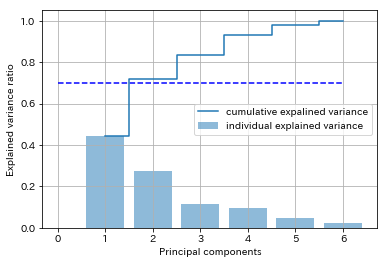

In [26]:
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(dataX)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

## 【問題4】クラスタ数kの選択

最適だと思われるクラスタ数 k を選択してください。  
エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

#### エルボー方を使ってみる。

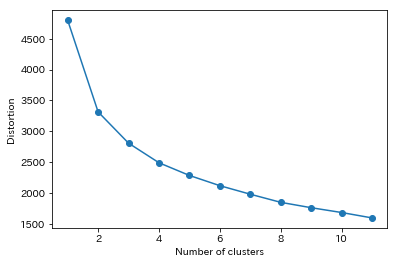

経過時間：0.8448848724365234


In [27]:
# 処理前の時刻
t1 = time.time() 
distortions = []
for i in range(1,12):
    km = ScratchKMeans(n_clusters=i,
                       seed=0)
    km.fit(dataX.values)                         # クラスタリングの計算を実行
    distortions.append(km.sse)   # km.fitするとkm.inertia_が得られる
plt.plot(range(1,12),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()    

#処理後の時刻
t2 = time.time()
 
# 経過時間を表示
elapsed_time = t2-t1
print('経過時間：{}'.format(elapsed_time))

2クラスタのところで、急激にSSEが下がっているので２クラスタで分けてみる。

## 【問題5】既知のグループとの比較

RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。  
クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

#### 2クラスタの場合

In [28]:
km = ScratchKMeans(n_clusters=2, seed=0)
km.fit(dataX.values)                         # クラスタリングの計算を実行
preddata = km.predict(dataX.values)
clust2 = np.concatenate([dataX.values,preddata.reshape(-1, 1)],axis=1)
columns = list(dataX.columns)
columns.append('cluster')
clust2 = pd.DataFrame(clust2, columns=columns)
clust2

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,9.447,9.175,8.931,5.366,7.891,7.199,0.000
1,8.862,9.191,9.166,7.474,8.100,7.482,0.000
2,8.757,9.083,8.947,7.785,8.165,8.968,0.000
3,9.493,7.087,8.348,8.765,6.229,7.489,1.000
4,10.026,8.596,8.882,8.273,7.483,8.554,0.000
5,9.150,9.019,8.542,6.501,7.493,7.280,0.000
6,9.403,8.071,8.850,6.174,8.052,6.301,0.000
7,8.933,8.508,9.151,7.420,8.108,7.850,0.000
8,8.693,8.202,8.731,6.052,7.448,6.620,0.000
9,8.701,9.314,9.846,7.055,8.913,7.649,0.000


In [29]:
# クラスタリングによってわけられてグループの平均
clust2.groupby('cluster').mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
0.000,8.261,8.921,9.385,6.750,8.432,6.818
1.000,9.062,7.557,7.776,7.690,5.625,6.557


In [30]:
# 元々のチャンネルカテゴリによって分けた場合の平均
data.groupby('Channel').mean()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,2.510,8.902,7.691,7.933,7.518,5.926,6.547
2,2.613,8.371,9.024,9.508,6.846,8.590,6.913


/Users/takahashiakira/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/takahashiakira/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


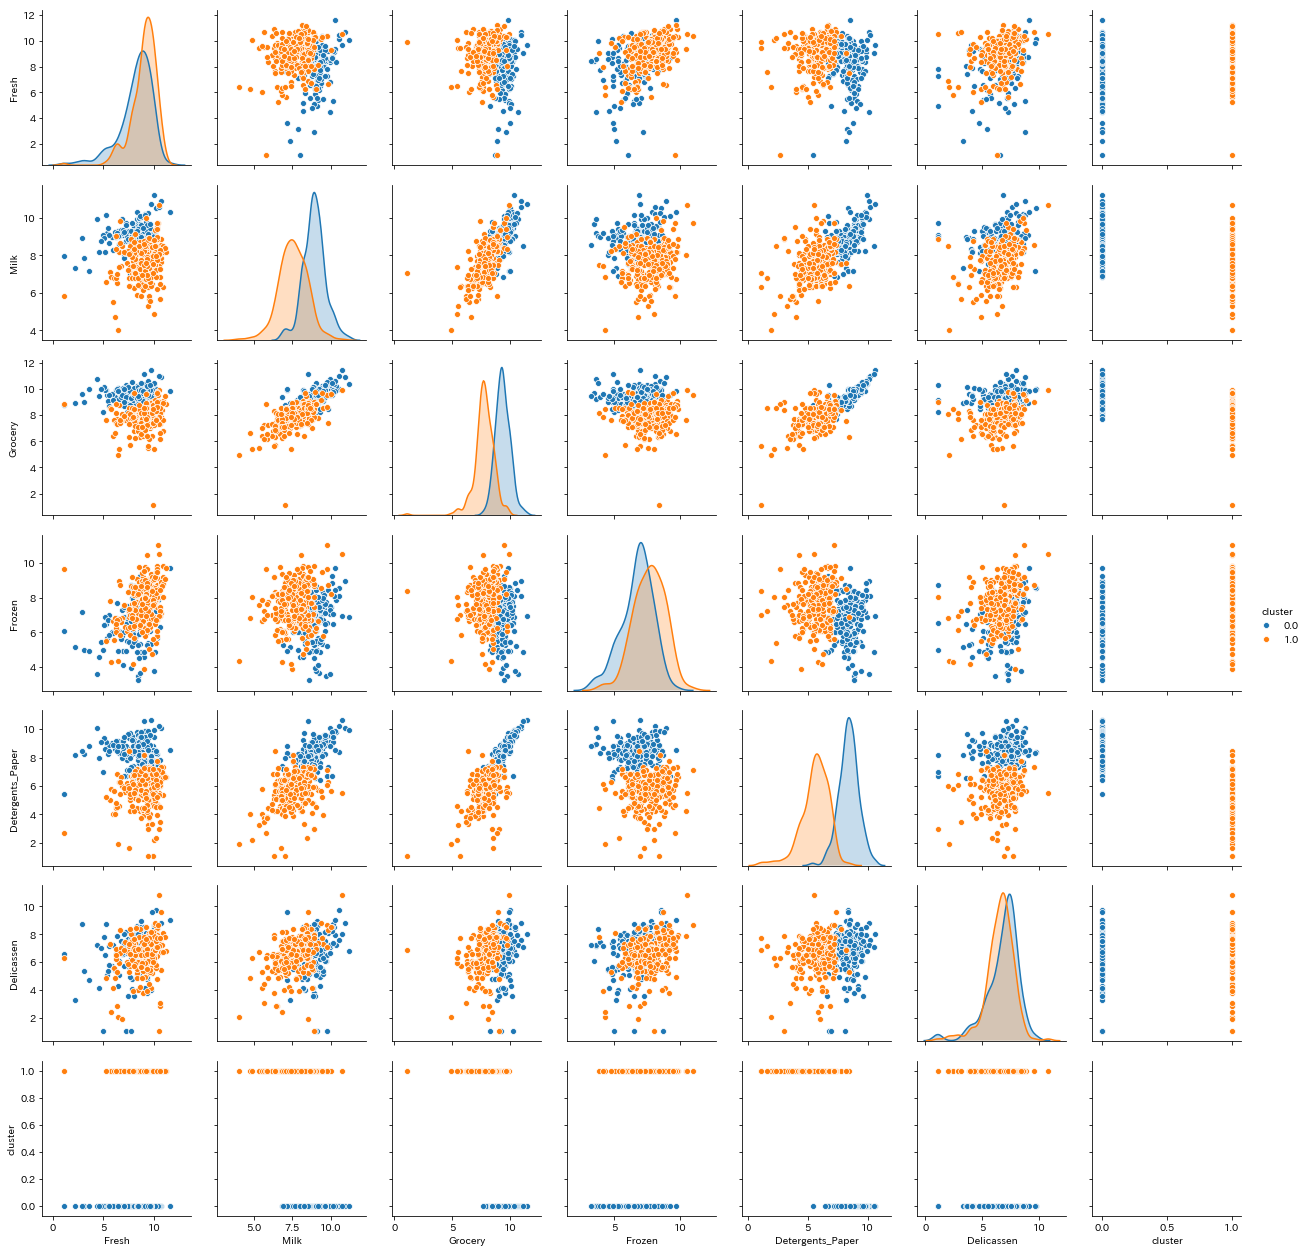

In [31]:
#クラスタによって分けた場合のプロット図
sns.pairplot(clust2, hue='cluster')

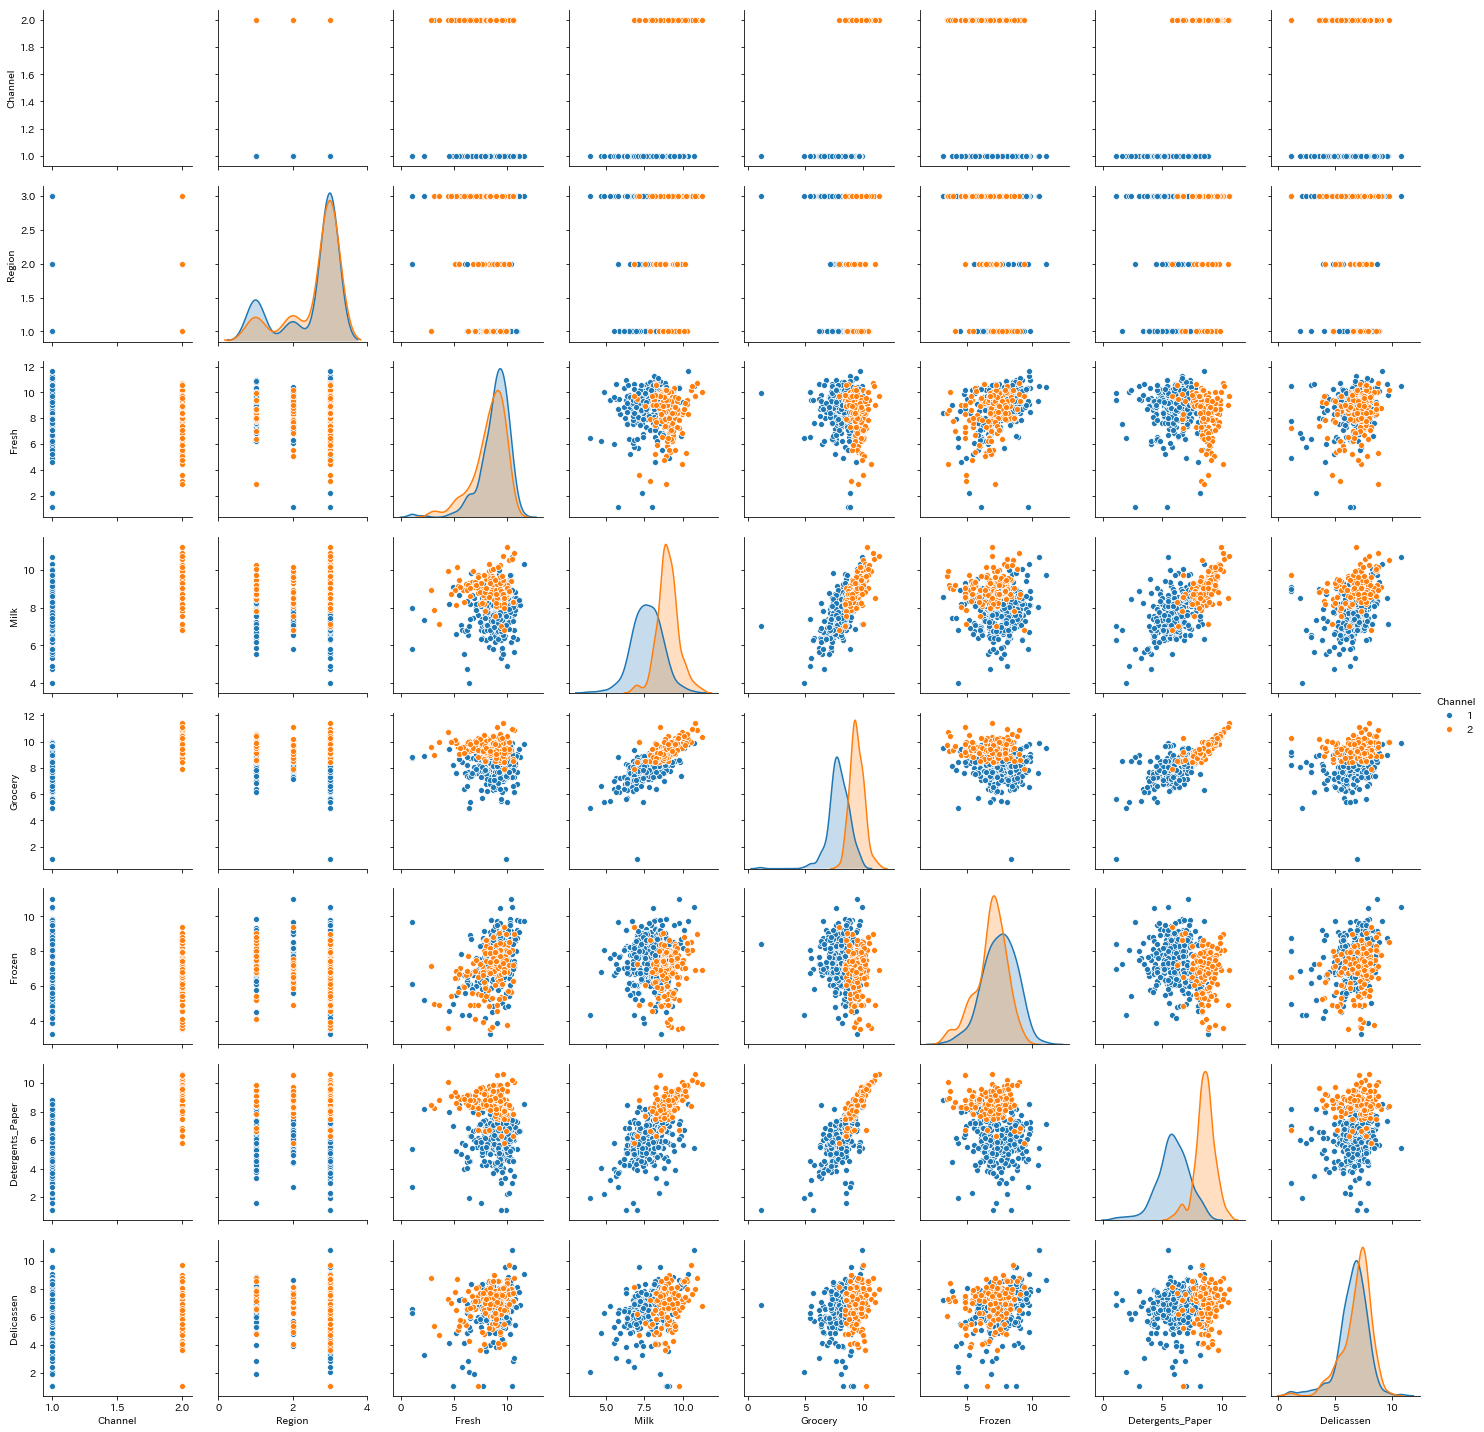

In [32]:
#チャンネルカテゴリに寄って分けた場合のプロット図
sns.pairplot(data, hue='Channel')

ほとんど、チャンネルカテゴリによって分けられたものと近い分けられ方となった。

## 【問題6】卸売業者にとって有益な情報

 先程のプロット図を確認した様にchannelによってだいぶ売れ筋や売れ方などが大きく変わってくるので、それぞれ別の対策を講じたほうが良い

## 【問題7】教師なし学習と教師あり学習

最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。  
- 教師なし学習は教師あり学習とどのような違いがあるか

教師なし学習は正解ラベルを与えない為、説明変数の特徴や、変数同士の関係性(距離など)を抽出していく。
教師あり学習はラベルを与えることで、説明変数と目的変数の関係性を抽出する。